# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

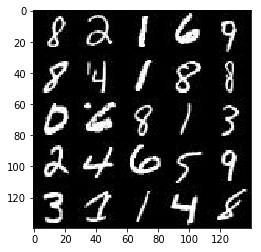

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

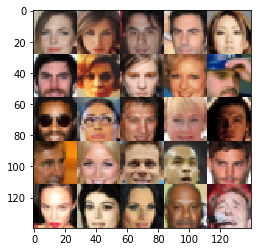

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learining_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learining_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        # images size  28,28, color_channels

        input_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        input_layer = tf.maximum(input_layer*alpha, input_layer)
        # images size  14,14, 64

        hl1 = tf.layers.conv2d(input_layer, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        hl1 = tf.layers.batch_normalization(hl1, training=True)
        hl1 = tf.maximum(hl1* alpha, hl1)
        # image size 7,7,128
        
        hl2 = tf.layers.conv2d(hl1, 256, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        hl2 = tf.layers.batch_normalization(hl2, training=True)
        hl2 = tf.maximum(hl2* alpha, hl2)
        # image size 7,7,256        
        

        flat = tf.reshape(hl2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)


        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):

    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.1

        input_layer=tf.layers.dense(z, 7*7*512)
        l1 = tf.reshape(input_layer, (-1, 7,7,512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(l1*alpha, l1)
        # image size 7x7x512

        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(l2*alpha, l2)
        # image size 14x14x256
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(l3*alpha, l3)
        # image size 28x28x128
        
        l4 = tf.layers.conv2d_transpose(l3, 64, 5, strides=1, padding='same')
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.maximum(alpha*l4, l4)
        #now 28x28x64        
        

        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides=1, padding='same')
        # image size 28x28xout_channel_dim

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    
    g_model = generator(input_z, out_channel_dim)
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=0.9*tf.ones_like(d_out_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
   
    n, image_width, image_height, image_channels = data_shape  
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
     
    steps = 0
    print_every = 100
    
    # -------------------------------------------------------------------------------------------

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                batch_images *= 2
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, 
                                                input_z: batch_z, 
                                                l_rate: learning_rate})

                two = sess.run(g_train_opt, feed_dict = {input_real: batch_images,
                                                input_z: batch_z,
                                                l_rate: learning_rate})

                if steps % print_every == 0:                    
                    training_d_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    training_g_loss = g_loss.eval({input_z: batch_z})
                    print("Discriminator Loss: {:.4f}".format(training_d_loss),
                         "Generator Loss: {:.4f}".format(training_g_loss))
                    
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Discriminator Loss: 0.4574 Generator Loss: 5.6196


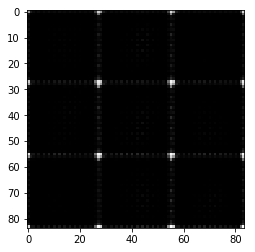

Discriminator Loss: 0.3668 Generator Loss: 8.7460


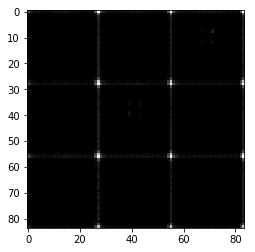

Discriminator Loss: 0.4354 Generator Loss: 4.9241


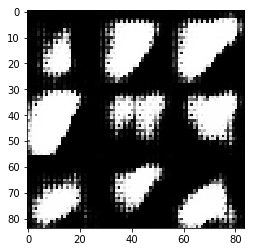

Discriminator Loss: 0.6881 Generator Loss: 3.1200


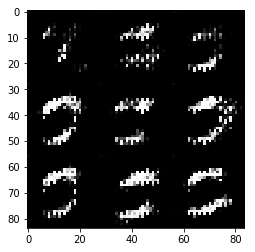

Discriminator Loss: 0.8185 Generator Loss: 3.4773


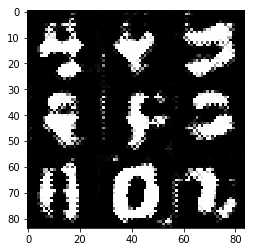

Discriminator Loss: 0.5590 Generator Loss: 3.0964


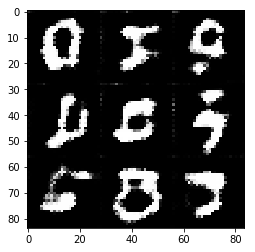

Discriminator Loss: 0.9067 Generator Loss: 1.3288


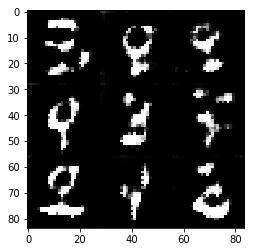

Discriminator Loss: 0.4359 Generator Loss: 3.7681


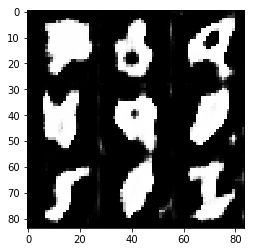

Discriminator Loss: 0.7185 Generator Loss: 2.3578


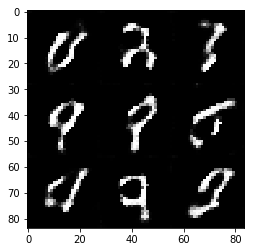

Discriminator Loss: 0.8227 Generator Loss: 2.7547


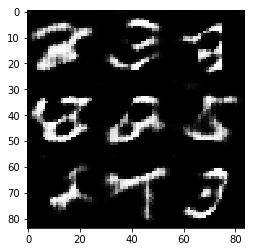

Discriminator Loss: 0.7804 Generator Loss: 1.6595


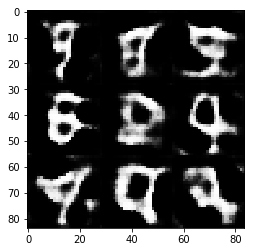

Discriminator Loss: 0.8500 Generator Loss: 1.3857


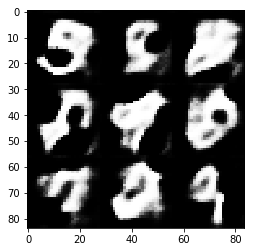

Discriminator Loss: 0.8022 Generator Loss: 2.6664


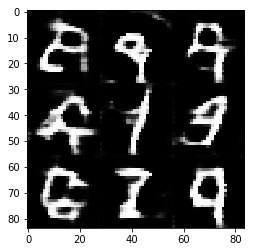

Discriminator Loss: 0.8639 Generator Loss: 1.8194


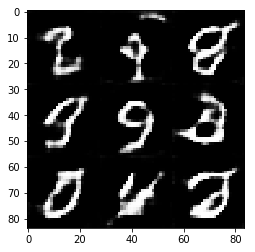

Discriminator Loss: 0.6026 Generator Loss: 2.5739


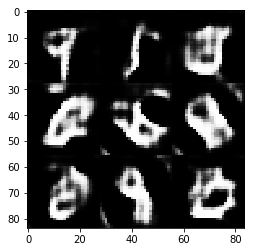

Discriminator Loss: 0.5209 Generator Loss: 3.0629


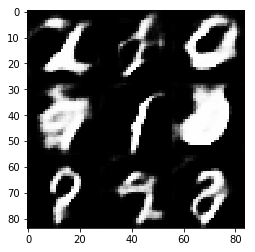

Discriminator Loss: 0.8263 Generator Loss: 1.4763


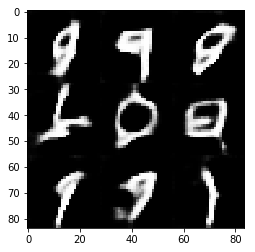

Discriminator Loss: 0.7811 Generator Loss: 2.4490


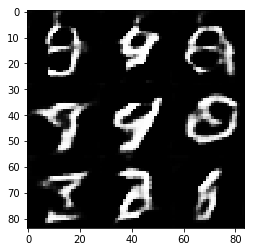

Discriminator Loss: 0.7838 Generator Loss: 3.1383


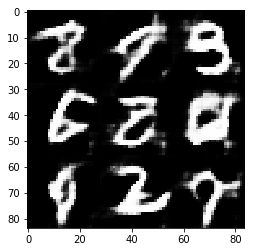

Discriminator Loss: 0.4798 Generator Loss: 3.2420


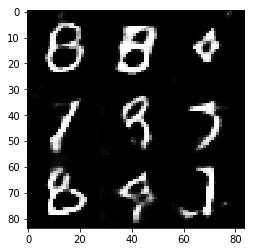

Discriminator Loss: 0.9909 Generator Loss: 1.1266


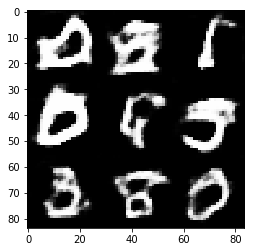

Discriminator Loss: 0.7474 Generator Loss: 2.0883


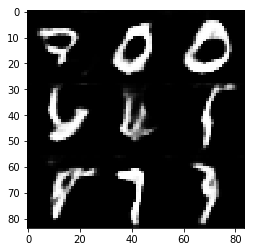

Discriminator Loss: 0.7000 Generator Loss: 2.1454


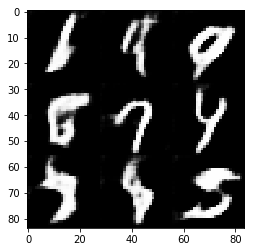

Discriminator Loss: 0.9206 Generator Loss: 1.3490


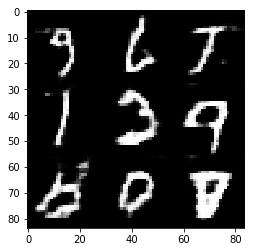

Discriminator Loss: 0.9924 Generator Loss: 1.5288


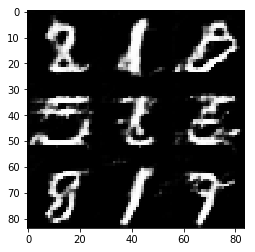

Discriminator Loss: 0.7632 Generator Loss: 2.3436


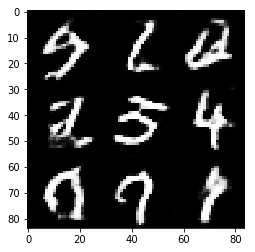

Discriminator Loss: 1.0268 Generator Loss: 0.9902


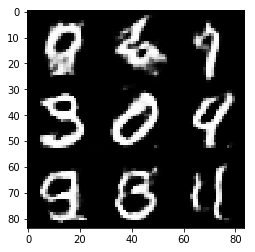

Discriminator Loss: 0.6390 Generator Loss: 2.3306


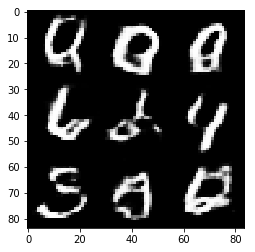

Discriminator Loss: 0.6762 Generator Loss: 1.7149


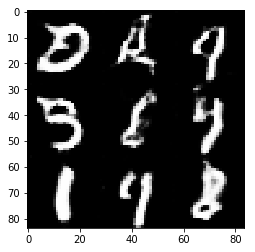

Discriminator Loss: 0.8748 Generator Loss: 1.7460


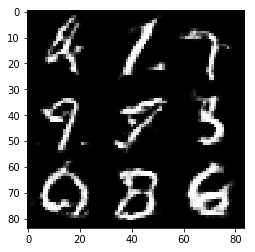

Discriminator Loss: 0.7887 Generator Loss: 2.1496


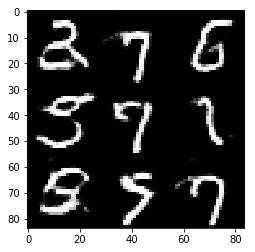

Discriminator Loss: 1.0577 Generator Loss: 1.6892


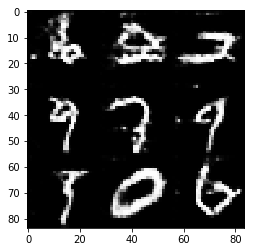

Discriminator Loss: 0.6508 Generator Loss: 2.1088


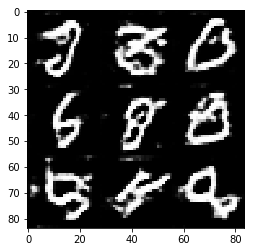

Discriminator Loss: 0.6798 Generator Loss: 3.1192


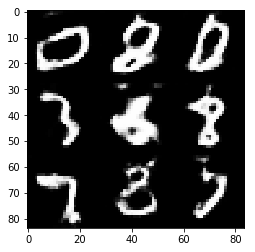

Discriminator Loss: 0.7178 Generator Loss: 1.8058


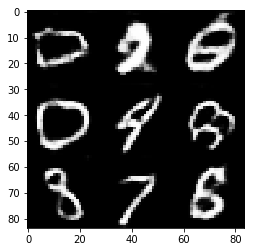

Discriminator Loss: 0.6202 Generator Loss: 2.6248


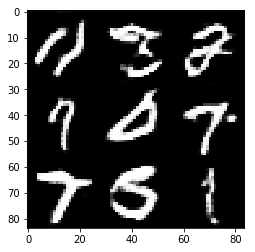

Discriminator Loss: 0.9430 Generator Loss: 2.5206


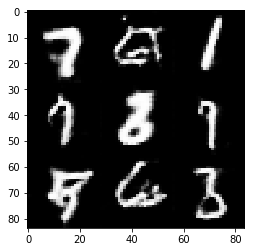

In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Discriminator Loss: 0.4284 Generator Loss: 4.0145


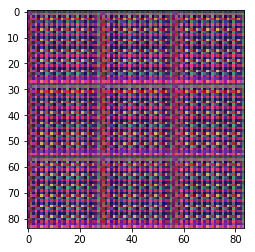

Discriminator Loss: 0.4838 Generator Loss: 3.6413


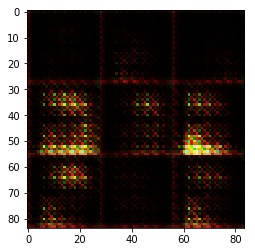

Discriminator Loss: 0.3789 Generator Loss: 4.6847


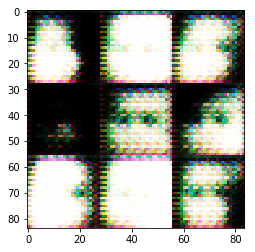

Discriminator Loss: 0.4049 Generator Loss: 3.6427


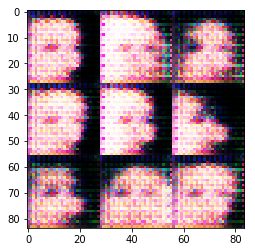

Discriminator Loss: 0.5082 Generator Loss: 4.3480


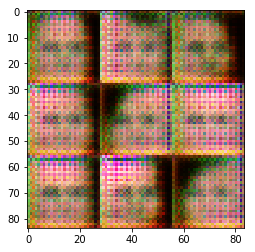

Discriminator Loss: 0.3867 Generator Loss: 3.9411


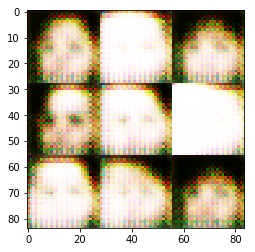

Discriminator Loss: 0.6041 Generator Loss: 2.7725


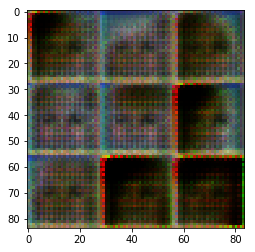

Discriminator Loss: 0.5299 Generator Loss: 2.3100


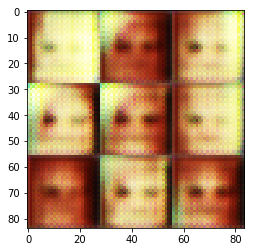

Discriminator Loss: 0.4179 Generator Loss: 6.1612


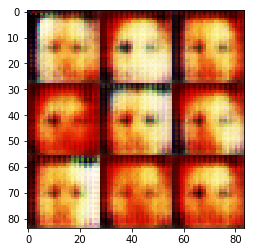

Discriminator Loss: 0.5273 Generator Loss: 3.0201


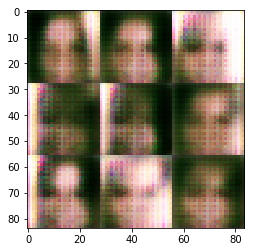

Discriminator Loss: 0.5864 Generator Loss: 2.4922


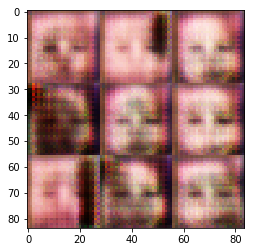

Discriminator Loss: 0.4932 Generator Loss: 3.0808


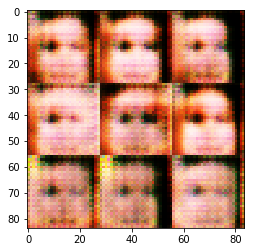

Discriminator Loss: 0.8095 Generator Loss: 2.0841


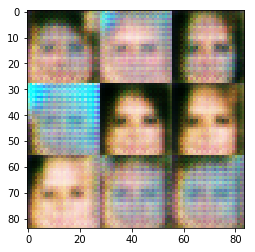

Discriminator Loss: 0.7251 Generator Loss: 2.3432


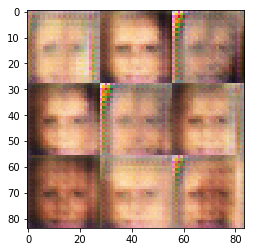

Discriminator Loss: 0.4475 Generator Loss: 4.4788


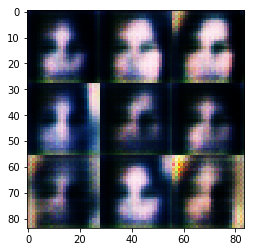

In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001

beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.